# How to create a synthetic sunpy map from projected 3D simulation data

This notebook will help you create a synthetic map compatible with Sunpy, oriented by a Coronal Loop Builder parameter file. If you need to create your first CLB parameter file, please see [eg_clb_loop.ipynb](eg_clb_loop.ipynb).

Let's first import our packages.

In [1]:
import matplotlib.pyplot as plt

from rushlight.utils.proj_imag_classified import SyntheticFilterImage as sfi
from rushlight.config import config

from CoronalLoopBuilder.builder import CoronalLoopBuilder # type: ignore
import sunpy

import aiastereo as aist

from astropy.coordinates import SkyCoord
import astropy.units as u


Also, let's define some settings for the run. 
- **CROPPED_DIR** + **AIA_IMG** / **STEREO_IMG** should be the path to your target AIA and STEREO maps, respectively
- **LOOP_PTH** (**LOOP_DIR** + **LOOP_FNAME**) should point to the pickled CLB parameter file (type dict) that defines the orientation of your projection

In [2]:
CROPPED_DIR = './observations_cropped/'
AIA_IMG = 'aia_94_2013.fits'
STEREO_IMG = '195_STEREO_2013-05-15T04:40:58.913.fits'

LOOP_DIR = './loop_params/'
LOOP_FNAME = 'aia_stereo_loop_195.pkl'
LOOP_PTH = LOOP_DIR + LOOP_FNAME


Let's load our aia and sdo maps from the **CROPPED_DIR** and ***_IMG** paths defined above.

In [3]:
aia_map = sunpy.map.Map(CROPPED_DIR + AIA_IMG)
# stereo_map = sunpy.map.Map(CROPPED_DIR + STEREO_IMG)
stereo_map = sunpy.map.Map('/mnt/My_Passport/Sabastian/xrt/2013_05_15/xrt_lvl_1/Open-Al_mesh/L1_XRT20130515_044348.3.fits')

Now, let's define some parameters for the projection to handle.
- **datacube** should refer to the path of the simulation data you would like to project. 
    - This can either be retrieved from **config.SIMULATIONS['DATASET']** (after calling **rushlight.config**), or you can explicity define `'your/path/as/a/string'`.
- **zoom** is a numerical value between 0 and 1, with larger values creating a larger projection within the viewing window.

In [4]:
# Remaining variables for sfi generation 
datacube = config.SIMULATIONS['DATASET']    # Path to 3D gaseous dataset to be projected
zoom = 0.4                                  # Zoom amount for projected box (0-1)

Here, we create a matplotlib figure with 4 panels: 2 observation-based sunpy maps, and 2 model-based sunpy maps.

We also overplot the previously generated coronal loop over each map for comparison. Adjust your zoom level to match the projection's apparent size to that of the coronal loop.

Loop length: 89.90717749124303 Mm
Loop length: 89.90717749124303 Mm
Loop length: 89.90717749124303 Mm


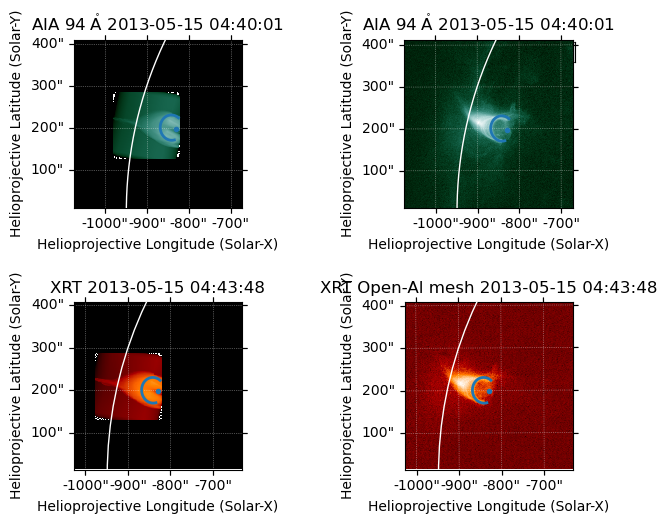

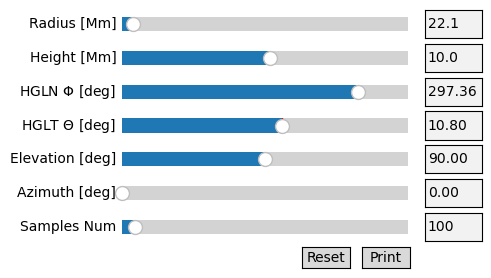

In [5]:
# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(2, 2, wspace=0.07)

# Generate aia-based SFI and plot synthetic, real maps
sfiObj1 = sfi(dataset=datacube, smap=aia_map, pkl=LOOP_PTH, zoom=zoom)   #TODO add in manual norm / north to call
ax1, synthmap1, norm1, north1, image_shift1 = sfiObj1.synthmap_plot(fig=subfigs[0,0], plot='synth')
ax2 = subfigs[0,1].add_subplot(projection=aia_map)
aia_map.plot(axes=ax2)
stereo_map.draw_limb(axes=ax1)
stereo_map.draw_limb(axes=ax2)

# Easier to access CLB parameter in dictionary form
loop_params = sfiObj1.dims

# Generate stereo-based SFI and plot synthetic, real maps
sfiObj2 = sfi(dataset=datacube, smap=stereo_map, pkl=LOOP_PTH, zoom=zoom)
ax3, synthmap2, norm2, north2, image_shift2 = sfiObj2.synthmap_plot(fig=subfigs[1,0], plot='synth')
ax4 = subfigs[1,1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax4)
stereo_map.draw_limb(axes=ax3)
stereo_map.draw_limb(axes=ax4)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2, ax3, ax4], [synthmap1, aia_map, synthmap2, stereo_map], **loop_params)


Additionally, you can plot the edges of the synthetic simulation box that you are using

Loop length: 89.90717749124303 Mm


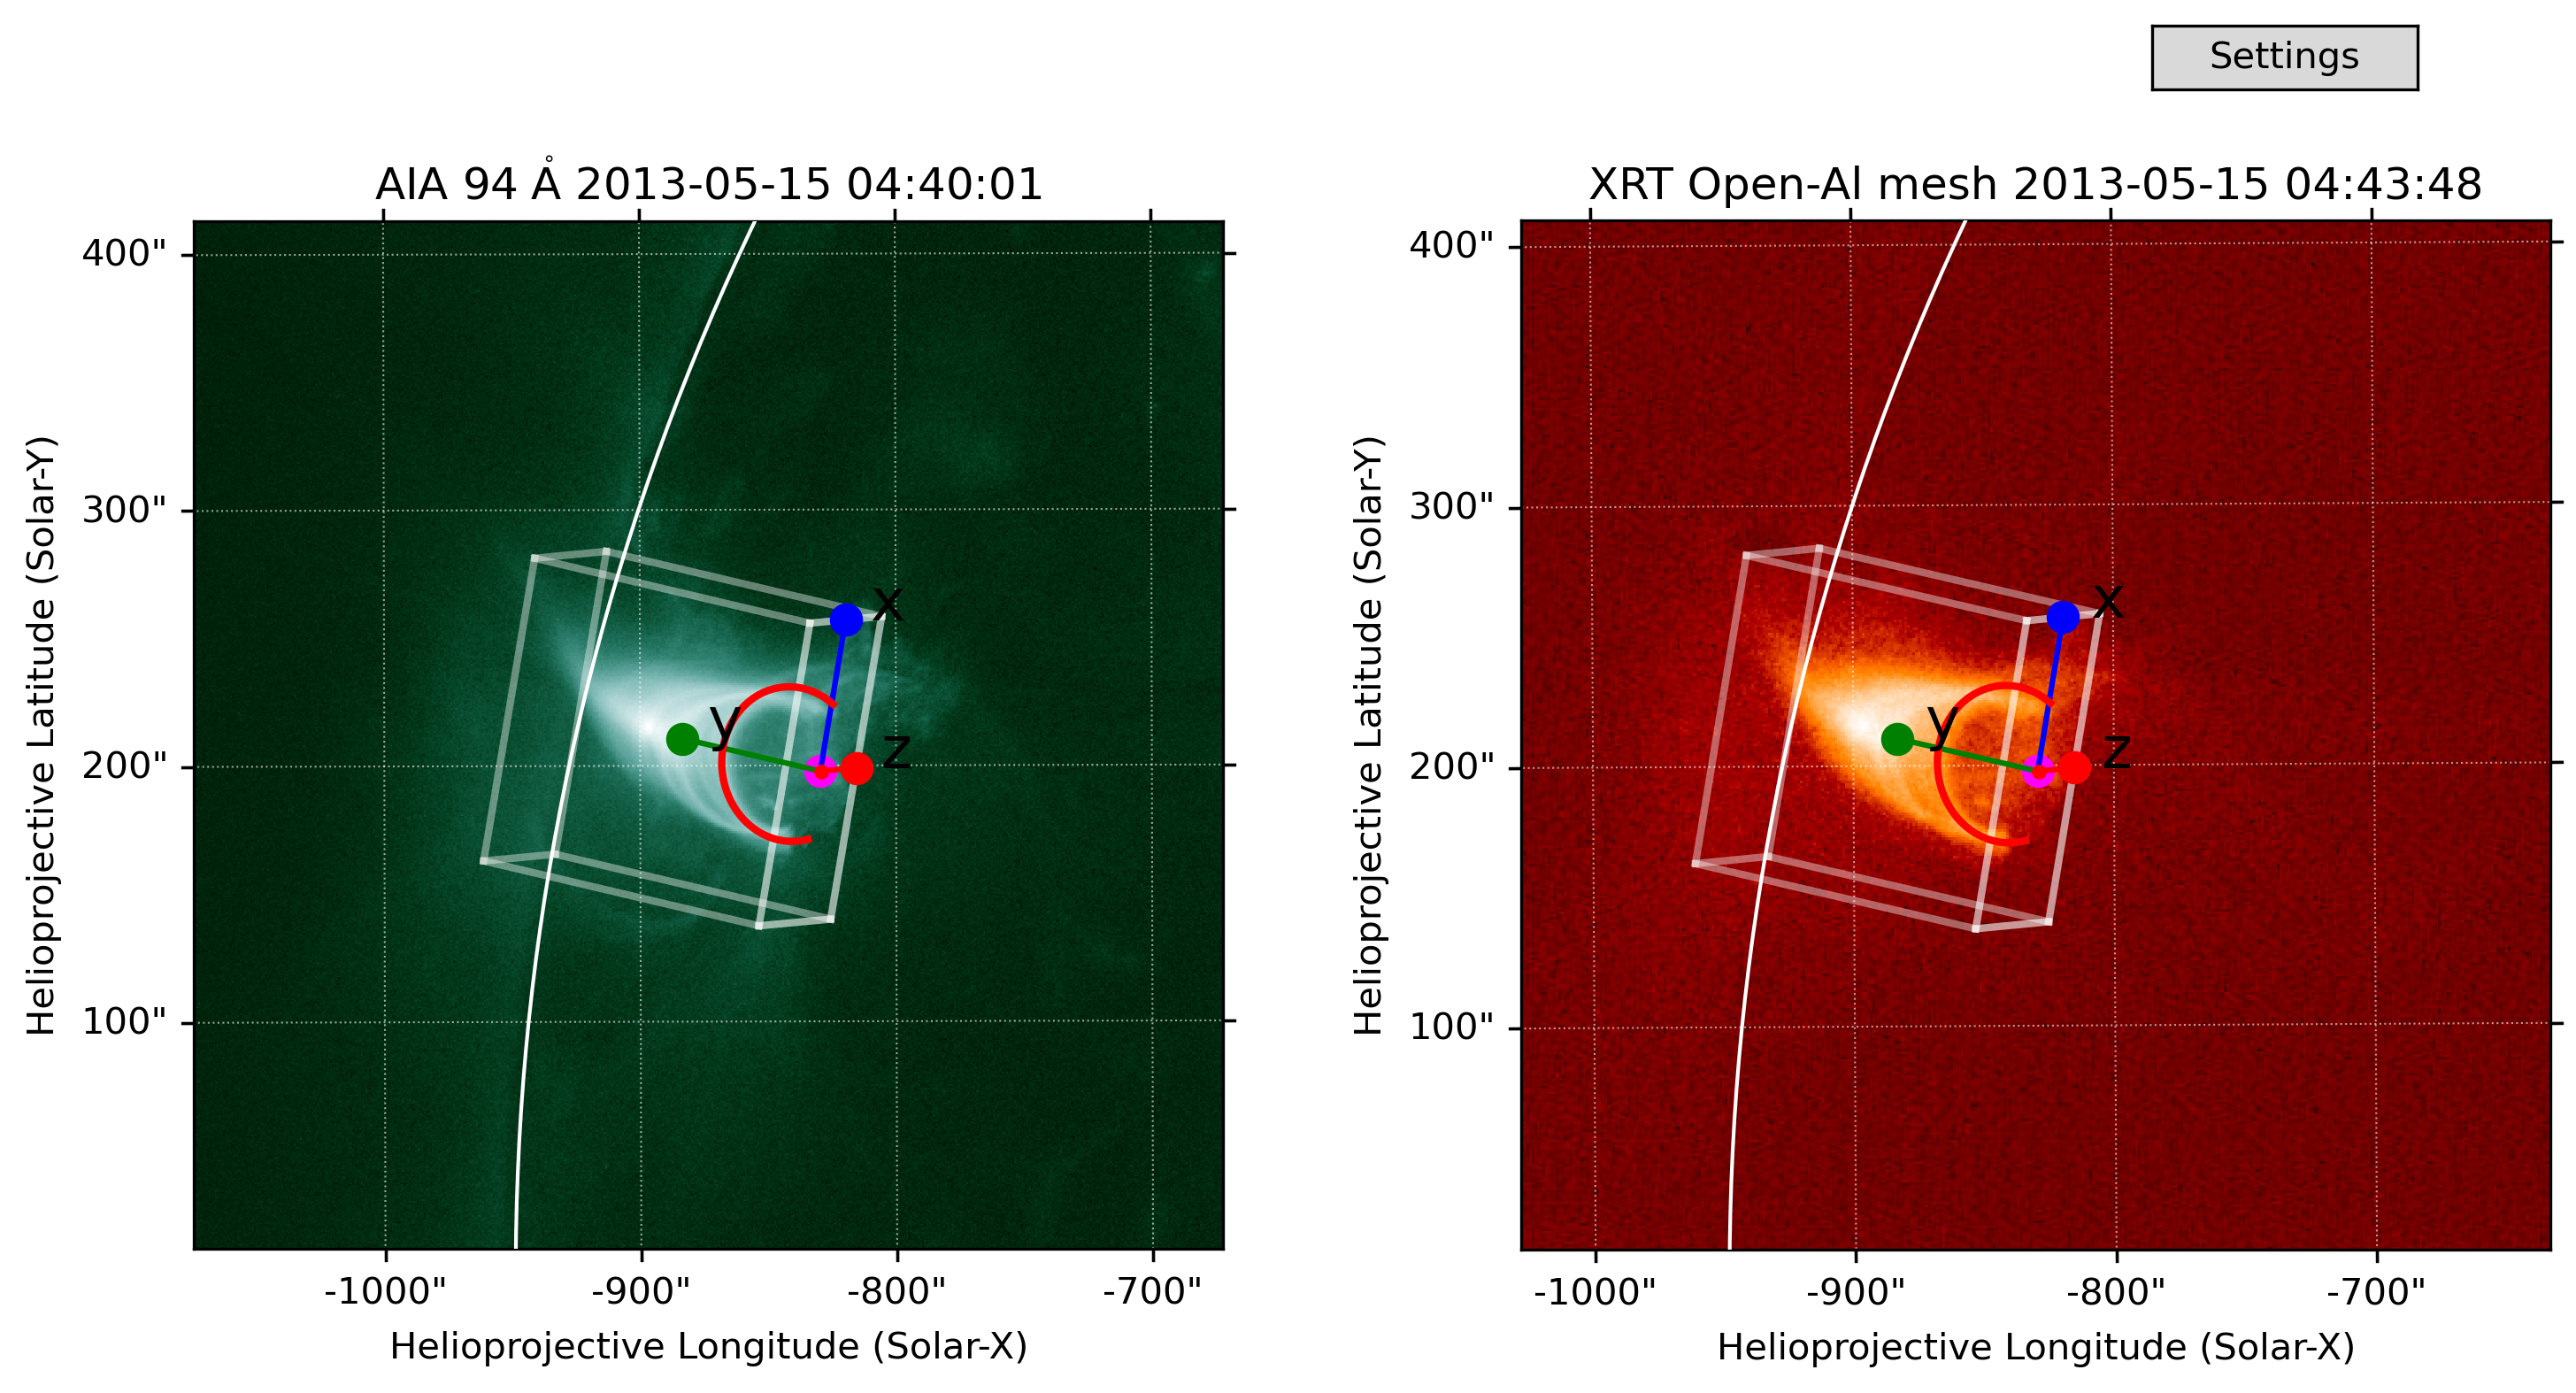

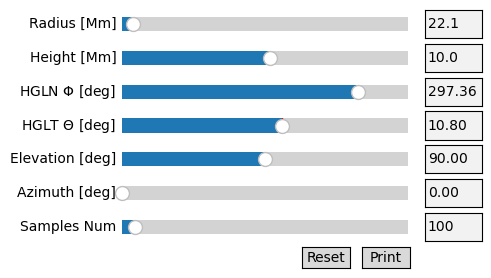

In [6]:
# Create figure with subplots
fig = plt.figure(figsize=(10,6), dpi=300)
subfigs = fig.subfigures(1, 2)

# Plot AIA map in the first subplot
ax1 = subfigs[0].add_subplot(projection=aia_map)
aia_map.plot(axes=ax1)
stereo_map.draw_limb(axes=ax1)

# Plot synthbox edges on aia map
aist.plot_edges(ax1, aia_map, sfiObj1, zoom=zoom, axes=True, xoffset=16, fontsize=16)

# Plot SDO map in the second subplot
ax2 = subfigs[1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax2)
stereo_map.draw_limb(axes=ax2)

# Plot synthbox edges on stereo map
aist.plot_edges(ax2, stereo_map, sfiObj2, zoom=zoom, axes=True)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2], [aia_map, stereo_map], ellipse=False, **loop_params, color='r')

Lastly, you can plot composite model-observation plots from the sfi object.

Loop length: 89.90717749124303 Mm


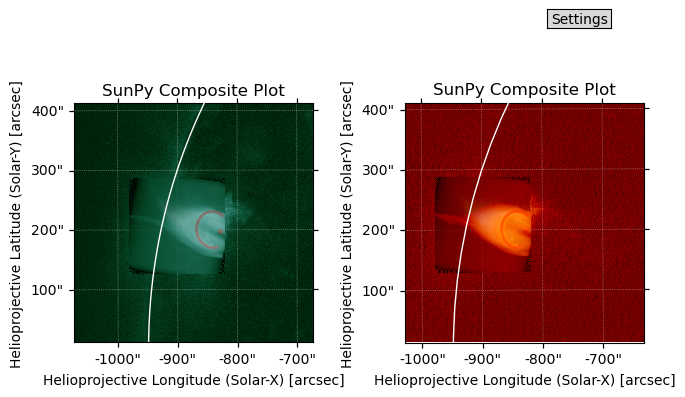

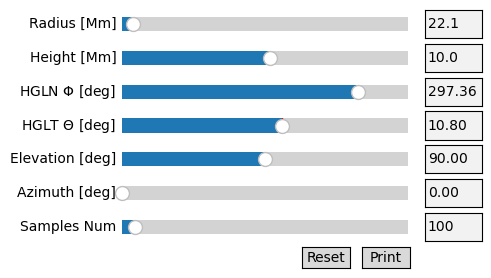

In [7]:
# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(1, 2, wspace=0.07)

# Generate aia-based SFI and plot composite real-synth map
ax1, synthmap1, norm, north, image_shift = sfiObj1.synthmap_plot(fig=subfigs[0], plot='comp', alpha = 0.75)
stereo_map.draw_limb(axes=ax1)

# Plot los from STEREO on the AIA map
aist.plot_los(ax1, stereo_map, aia_map, loop_params=loop_params)

# Generate stereo-based SFI and plot composite real-synth map
ax2, synthmap2, norm, north, image_shift = sfiObj2.synthmap_plot(fig=subfigs[1], plot='comp', alpha = 0.75)
stereo_map.draw_limb(axes=ax2)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2], [synthmap1, synthmap2], ellipse=False, **loop_params, color='r')